In [17]:
import numpy as np
import numpy.linalg as lin
import sklearn as skl
from sklearn.model_selection import KFold

In [18]:
def getZ(label:str) -> int:    
    elements="H   He\
        Li  Be  B   C   N   O   F   Ne\
        Na  Mg  Al  Si  P   S   Cl  Ar\
        K   Ca  Sc  Ti  V   Cr  Mn  Fe  Co  Ni  Cu  Zn  Ga  Ge  As  Se  Br  Kr\
        Rb  Sr  Y   Zr  Nb  Mo  Tc  Ru  Rh  Pd  Ag  Cd  In  Sn  Sb  Te  I   Xe\
        Cs  Ba  La  Ce  Pr  Nd  Pm  Sm  Eu  Gd  Tb  Dy  Ho  Er  Tm  Yb\
        Lu  Hf  Ta  W   Re  Os  Ir  Pt  Au  Hg  Tl  Pb  Bi  Po  At  Rn\
        Fr  Ra  Ac  Th  Pa  U".split()    
    
    return elements.index(label)+1

In [19]:
def importQM7(structure_file:str, energy_file:str):
    """
    Return: Z, R, E\n
    Z: list of 1D-arrays containing atomic identities\n
    R: list of 2D-arrays containing atomic positions\n
    E: 1D-array containing atomization energy\n
    """
    structures = open(structure_file,  'r').readlines()

    Z = []
    R = []
    E = []
    n_max = 0

    for line in range(len(structures)):
        x = structures[line].split()

        #Check for start of molecule structure data:
        if len(x) == 1:
            n_atoms = int(x[0])
            if n_atoms > n_max: n_max = n_atoms

            Zs   = np.zeros(n_atoms)
            xyzs = np.zeros((n_atoms, 3))

            #Go through every atom in the molecule:
            atom_index = 0
            for j in range(line+2, line+2+n_atoms):
                Zs  [atom_index] = getZ(structures[j].split()[0])
                xyzs[atom_index] = np.array([float(val) for val in structures[j].split()[1:]])

                atom_index += 1
            
            Z.append(Zs)
            R.append(xyzs)
        
    file = open(energy_file,  'r').readlines()
    for line in range(len(file)):
        E.append(float(file[line].split()[0]))
    
    return Z, R, E

In [20]:
def trainTestSplit(nData:int, nTrain:int):
    assert nData > nTrain
    nTest = nData - nTrain

    index   = np.array([i for i in range(nData)])
    np.random.shuffle(index)

    training_index = index[0:nTrain]
    testing_index  = index[nTrain:]

    return training_index, testing_index

In [21]:
def stratSplit(nData:int, nTrain:int, k:int, y):
    assert nData  > nTrain
    assert nData == len(y)

    sortedIndex = np.argsort(y)
    strata = [[] for _ in range(k)]

    max_strata = nTrain // k
    
    for i in range(k):
        sample = i
        selected = 0 
        
        while selected < nData:
            if sample >= nData: break
            strata[i].append(sortedIndex[sample])
            sample   += k
            selected += 1

    for i in range(len(strata)):
        np.random.shuffle(strata[i])
    
    trainingIndex = np.array([])
    testingIndex  = np.array([])

    for i in range(k):
        per_strata = max_strata

        if len(trainingIndex) + max_strata > nTrain:
            per_strata = nTrain - len(trainingIndex)

        if (i == k-1) and (len(trainingIndex) + per_strata < nTrain):
            per_strata = nTrain - len(trainingIndex)
            
        trainingIndex = np.concatenate((trainingIndex, strata[i][:per_strata]), 
                                        casting="unsafe", dtype=int)
        testingIndex  = np.concatenate((testingIndex,  strata[i][per_strata:]), 
                                        casting="unsafe", dtype=int)

    assert len(trainingIndex) == nTrain        , \
        f"Unexpected array size. {len(trainingIndex)} != {nTrain}"
        
    assert len(testingIndex ) == nData - nTrain, \
        f"Unexpected array size. {len(trainingIndex)} != {nData - nTrain}"
    
    return trainingIndex, testingIndex

In [22]:
def coulomb_eigenvalues(Z, R, n_max):
    n_mols = len(Z)
    n_max  = n_max
    #Generate Descriptors, eigenvalues of Coulomb Matrix M
    coulomb_eVs = np.zeros((n_mols, n_max))
    
    for k in range(n_mols):
        n_atoms = len(Z[k])

        M = np.zeros((n_atoms, n_atoms))

        for i in range(n_atoms):
            for j in range(n_atoms):
                if i == j:
                    M[i][j] = 0.5 * (Z[k][i])**2.4
                else:
                    M[i][j] = (Z[k][i]*Z[k][j]) / lin.norm(R[k][i] - R[k][j])**2

        eigenValues = lin.eigvals(M)
        sorted_eVal = np.array(sorted(eigenValues, key=abs, reverse=True))

        #Append 0s to match molecule with largest number of eigenvalues
        if n_atoms == n_max:
            coulomb_eVs[k] = sorted_eVal
        else:
            coulomb_eVs[k] = np.concatenate((sorted_eVal, [0]*(n_max-n_atoms)))

    return coulomb_eVs

In [23]:
def euclidian_norm(v1, v2):
    assert len(v1) == len(v2), "Vectors must be same size."
    tmp = (v1 - v2)**2

    return np.sqrt(np.sum(tmp))

In [24]:
def KRR_evaluate(x, X, alphas, sigma):
    sum = 0
    for i in range(len(alphas)):
        sum += alphas[i]*np.exp(-euclidian_norm(x, X[i])**2 / (2*sigma**2))
    return sum

In [25]:
def KRR_parallel_evaluate(testing_data, training_data, alphas, sigma):
    predictions = np.zeros(len(testing_data))

    U = training_data.T

    for i in range(len(testing_data)):
        v = testing_data[i][:, np.newaxis]
        arg = np.sum((U - v)**2, axis=0)
        arg = np.exp(-arg/(2*sigma**2))

        predictions[i] = np.sum(np.multiply(arg, alphas))

    return predictions

In [26]:
def KKR_train(training_data, training_trgt, sigma, lamda):
    K = np.zeros((len(training_data), len(training_data)))

    for i in range(len(training_data)):
        for j in range(len(training_data)):
            K[i][j] = np.exp(-euclidian_norm(training_data[i], training_data[j])**2 / (2*sigma**2))
    
    lambdaI = np.identity(len(training_data))*lamda
    alphas  = lin.inv(K + lambdaI)@training_trgt

    mae = 0
    for i in range(len(training_data)):
        pred = KRR_evaluate(training_data[i], training_data, alphas, sigma) 
        mae += np.abs(pred - training_trgt[i])
    
    return alphas, mae

In [27]:
model_size = 1000

Z_small, R_small, E_small = importQM7(structure_file = "qm7/sorted/qm7_small.txt", 
                                      energy_file    = "qm7/sorted/PBE0_small.txt")
Z_rest,  R_rest,  E_rest  = importQM7(structure_file = "qm7/sorted/qm7_rest.txt", 
                                      energy_file    = "qm7/sorted/PBE0_rest.txt")

strat_train, strat_test = stratSplit(nData  = len(Z_rest),
                                     nTrain = model_size - len(Z_small),
                                     k = 5,
                                     y = E_rest)

Z_train, R_train, E_train = Z_small, R_small, E_small
Z_test , R_test , E_test  = [], [], []


for i in range(len(strat_train)):
    Z_train.append(Z_rest[strat_train[i]])
    R_train.append(R_rest[strat_train[i]])
    E_train.append(E_rest[strat_train[i]])

for i in range(len(strat_test)):
    Z_test.append(Z_rest[strat_test[i]])
    R_test.append(R_rest[strat_test[i]])
    E_test.append(E_rest[strat_test[i]])


if (len(max(Z_train, key=len)) != len(max(Z_test, key=len))):
    print("Mismatch in maximum molecule size between training and testing sets. Be cautious.")

n_max = max(len(max(Z_train, key=len)),
            len(max(Z_test, key=len)))

Mismatch in maximum molecule size between training and testing sets. Be cautious.


In [28]:
training_data = coulomb_eigenvalues(Z=Z_train, R=R_train, n_max=n_max)
training_trgt = np.array(E_train)

testing_data  = coulomb_eigenvalues(Z=Z_test, R=R_test, n_max=n_max)
testing_trgt  = np.array(E_test)

Solving: 

$\min_\alpha \sum_i(E^\text{est}(M_i) - E^\text{ref}_i)^2 + \lambda\sum_i \alpha_i^2$

In [33]:
def trainingLoop(training_data, training_trgt, sigmas, lambdas, kfold:int,):

    kf = KFold(n_splits = kfold)
    MAEs = np.zeros((len(sigmas), len(lambdas)))

    cvs = 1
    for i in range(len(sigmas)):
        for j in range(len(lambdas)):
            print(f"CV {cvs} of {len(sigmas)*len(lambdas)}", end="\r")
            cvs += 1
            fold_errors = np.zeros(kfold)

            for k, (train_index, valid_index) in enumerate(kf.split(training_data)):

                train_data = training_data[train_index]
                train_trgt = training_trgt[train_index]
                valid_data = training_data[valid_index]
                valid_trgt = training_trgt[valid_index]

                alphas, mae = KKR_train(
                                training_data = train_data,
                                training_trgt = train_trgt,
                                sigma = sigmas [i],
                                lamda = lambdas[j])

                for n in range(len(valid_index)):
                    pred = KRR_evaluate(x = valid_data[n],
                                        X = train_data,
                                        alphas = alphas,
                                        sigma = sigmas[i])
                    
                    fold_errors[k] += np.abs(pred - valid_trgt[n])

            MAEs[i, j] = np.mean(fold_errors)
                
    optimal = np.unravel_index(MAEs.argmin(), MAEs.shape)

    opt_sig = sigmas [optimal[0]]
    opt_lam = lambdas[optimal[1]]
    print(f"Optimal hyperparameters:\n \
          Sigma : {opt_sig}\n \
          Lambda: {opt_lam}")

    return opt_sig, opt_lam, MAEs

In [30]:
def trainingLoop2(training_data, training_trgt, sigmas, lambdas, kfold:int,):

    kf = KFold(n_splits = kfold)
    MAEs = np.zeros((len(sigmas), len(lambdas)))

    cvs = 1
    for i in range(len(sigmas)):
        for j in range(len(lambdas)):
            print(f"CV {cvs} of {len(sigmas)*len(lambdas)}", end="\r")
            cvs += 1
            fold_errors = np.zeros(kfold)

            for k, (train_index, valid_index) in enumerate(kf.split(training_data)):

                train_data = training_data[train_index]
                train_trgt = training_trgt[train_index]
                valid_data = training_data[valid_index]
                valid_trgt = training_trgt[valid_index]

                alphas, mae = KKR_train(
                                training_data = train_data,
                                training_trgt = train_trgt,
                                sigma = sigmas [i],
                                lamda = lambdas[j])

                preds = KRR_parallel_evaluate(
                    testing_data  = valid_data,
                    training_data = train_data,
                    sigma  = sigmas[i],
                    alphas = alphas
                )
                    
                fold_errors[k] = np.sum(np.abs(preds - valid_trgt))

            MAEs[i, j] = np.mean(fold_errors)
                
    optimal = np.unravel_index(MAEs.argmin(), MAEs.shape)

    opt_sig = sigmas [optimal[0]]
    opt_lam = lambdas[optimal[1]]
    print(f"Optimal hyperparameters:\n \
          Sigma : {opt_sig}\n \
          Lambda: {opt_lam}")

    return opt_sig, opt_lam, MAEs

In [32]:
sigmas  = [2**i  for i in range(6,  10)]
lambdas = [10**i for i in range(-8, -5)]

sig, lam, MAEs = trainingLoop(training_data, training_trgt, sigmas=sigmas, lambdas=lambdas, kfold=3)

IndexError: list index out of range

In [35]:
alphas, mae = KKR_train(training_data = training_data,
                        training_trgt = training_trgt,
                        sigma = 256,
                        lamda = 0.001)

In [36]:
preds = []

for i in range(len(testing_data)):
    preds.append(KRR_evaluate(testing_data[i], training_data, alphas, sigma=256))

In [37]:
import matplotlib.pyplot as plt

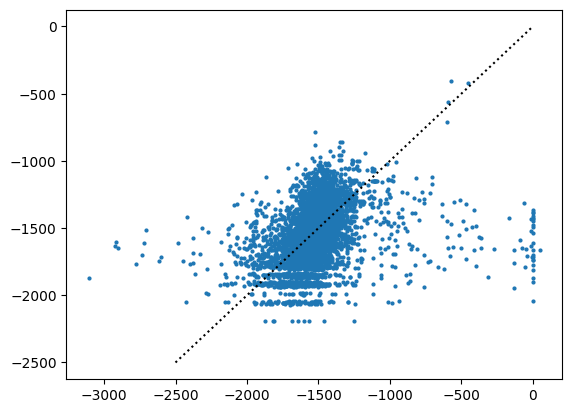

In [38]:
plt.scatter(preds, testing_trgt, s= 4)
plt.plot([-2500, 0], [-2500, 0], color="black", linestyle=":")

In [39]:
preds = np.array(preds)

mae = np.mean(np.abs(preds - testing_trgt))

print(mae)

169.20123413214793
